In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

In [29]:
from ngboost import NGBClassifier
from ngboost.distns import Bernoulli,k_categorical
from ngboost.learners import default_tree_learner

In [2]:
from sklearn.metrics import classification_report
from display_results import confusion_matrix

In [3]:
df_activity = pd.read_csv("activities.csv")

In [4]:
def segmentation(x_data,y,overlap_rate,time_window):
    
    seg_data = []
    overlap = int((1 - overlap_rate)*time_window)
    y_segmented_list = []
    
    for i in range(0,x_data.shape[0],overlap):
        seg_data.append(x_data[i:i+time_window])
        y_segmented_list.append(y)

    return seg_data,y_segmented_list

In [5]:
def handle_missing_values(df):
    df['x']=df['x'].replace(0, np.nan)
    df['y']=df['y'].replace(0, np.nan)
    df['z']=df['z'].replace(0, np.nan)
    return df

In [47]:
change_act_id = {2:0, 3:1, 4:2, 6:3, 9:4, 12:5}

In [45]:
def get_act_id(seg_id):
    seg = df_activity[df_activity["segment_id"]==seg_id]
    activity_id = seg["activity_id"].values
    return change_act_id[int(activity_id)]

In [46]:
def load_data(csv_file):

    y_list = []
    x_data_list = []

    csv_df = pd.read_csv(csv_file)
    csv_df = handle_missing_values(csv_df)
    csv_df.dropna(inplace=True)
    x_data = csv_df.values
    act_id = get_act_id(int(os.path.splitext(os.path.basename(csv_file))[0].replace("segment","")))
    
    return x_data,act_id

In [48]:
def get_features(x_data):
    features = []
    for i in range(x_data.shape[1]):
        # std
        features.append(x_data.T[i].std(ddof=0))
        # avg
        features.append(np.average(x_data.T[i]))
        # max
        features.append(np.max(x_data.T[i]))
        # min
        features.append(np.min(x_data.T[i]))
    return features

In [42]:
csv_files = glob("train/*")

In [43]:
X_feature_data_list = []
y_list = []
for csv_file in csv_files:
    x,y = load_data(csv_file)
    X_feature_data_list.append(get_features(x))
    y_list.append(y)

In [51]:
X_train,X_test,y_train,y_test = train_test_split(X_feature_data_list,y_list,test_size=0.3)

In [52]:
model_ml = RandomForestClassifier(n_estimators=500,n_jobs=-1)

In [53]:
model_ml.fit(X_train,y_train)
y_predict = model_ml.predict(X_test)

In [54]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.42      0.83      0.56         6
           1       1.00      0.67      0.80        15
           2       0.67      0.29      0.40         7
           3       0.50      0.33      0.40         6
           4       0.43      0.60      0.50         5
           5       0.67      0.80      0.73        15

    accuracy                           0.63        54
   macro avg       0.61      0.59      0.56        54
weighted avg       0.69      0.63      0.63        54



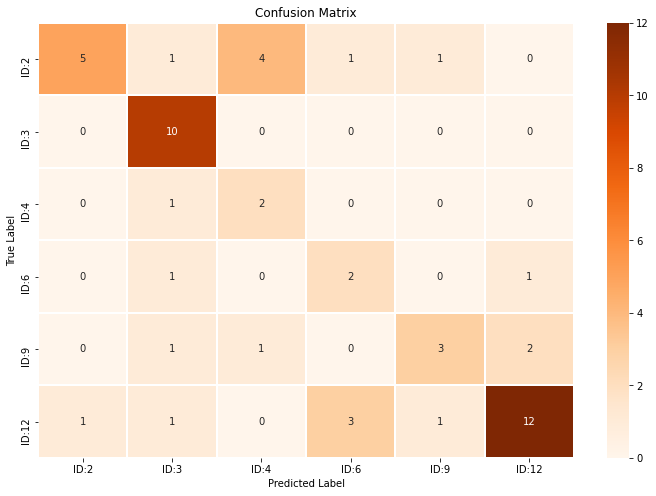

None


In [55]:
print(confusion_matrix(y_test, y_predict))

In [58]:
ngb = NGBClassifier(Dist = k_categorical(6))
ngb.fit(X_train, y_train)

[iter 0] loss=1.7464 val_loss=0.0000 scale=0.5000 norm=3.6180
[iter 100] loss=0.5734 val_loss=0.0000 scale=2.0000 norm=4.4797
[iter 200] loss=0.2855 val_loss=0.0000 scale=4.0000 norm=6.6994
[iter 300] loss=0.2065 val_loss=0.0000 scale=2.0000 norm=3.0851
[iter 400] loss=0.1836 val_loss=0.0000 scale=1.0000 norm=1.5061


NGBClassifier(Base=DecisionTreeRegressor(ccp_alpha=0.0,
                                         criterion='friedman_mse', max_depth=3,
                                         max_features=None, max_leaf_nodes=None,
                                         min_impurity_decrease=0.0,
                                         min_impurity_split=None,
                                         min_samples_leaf=1,
                                         min_samples_split=2,
                                         min_weight_fraction_leaf=0.0,
                                         presort='deprecated',
                                         random_state=None, splitter='best'),
              Dist=<class 'ngboost.distns.categorical.k_categorical.<locals>.Categorical'>,
              Score=<class 'ngboost.scores.LogScore'>, col_sample=1.0,
              learning_rate=0.01, minibatch_frac=1.0, n_estimators=500,
              natural_gradient=True,
              random_state=RandomState(MT1

In [59]:
y_predict_ngboost =ngb.predict(X_test)

In [60]:
print(classification_report(y_predict_ngboost,y_test))

              precision    recall  f1-score   support

           0       0.50      0.75      0.60         4
           1       0.67      0.62      0.65        16
           2       0.29      0.29      0.29         7
           3       0.17      0.33      0.22         3
           4       0.40      0.40      0.40         5
           5       0.73      0.58      0.65        19

    accuracy                           0.54        54
   macro avg       0.46      0.50      0.47        54
weighted avg       0.58      0.54      0.55        54



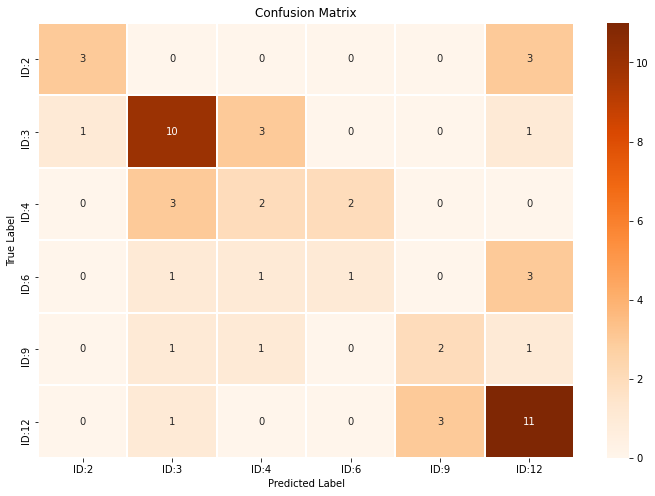

In [61]:
confusion_matrix(y_predict_ngboost,y_test)